# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [5]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [6]:
# Basic Imports
import os
import sys
import copy
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Others
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,confusion_matrix


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [7]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [8]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [9]:
# Loading the dataset1
folder1 = './dataset/IMFDB/'
folder2 = './dataset/IIIT-CFW/'
folder3 = './dataset/Yale_face_database/'

X1,y1 = load_data(folder1)
X2,y2 = load_data(folder2)
X3,y3 = load_data(folder3)

N1,H1,W1 = X1.shape[0:3]
N3,H3,W3 = X3.shape[0:3]
N2,H2,W2 = X2.shape[0:3]

if opt['is_grayscale']:
    C1 = 1 
    C2 = 1
    C3 = 1
else: 
    C1 = X1.shape[3]
    C2 = X2.shape[3]
    C3 = X3.shape[3]
    
# print(type(X1[0,0,0]))

Dataset shape: (400, 32, 32)
Dataset shape: (672, 32, 32)
Dataset shape: (165, 32, 32)


# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [10]:
# Flatten to apply PCA/LDA
# X = X.reshape((N,H*W*C))


###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [11]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X1 = pca.fit_transform(X)
    X2 = pca.inverse_transform(X1)
    return X1,X2

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [12]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [13]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [14]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [15]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [16]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [17]:
# Compute your features 

def featureComputation(X,N,H,W,C,K):
    X=X.reshape((N,H*W*C))
    Xk,Xkt=get_pca(X,K)
    print(Xk.shape)

featureComputation(X1,N1,H1,W1,C1,50)
featureComputation(X2,N2,H2,W2,C2,100)
featureComputation(X3,N3,H3,W3,C3,20)

(400, 50)
(672, 100)
(165, 20)


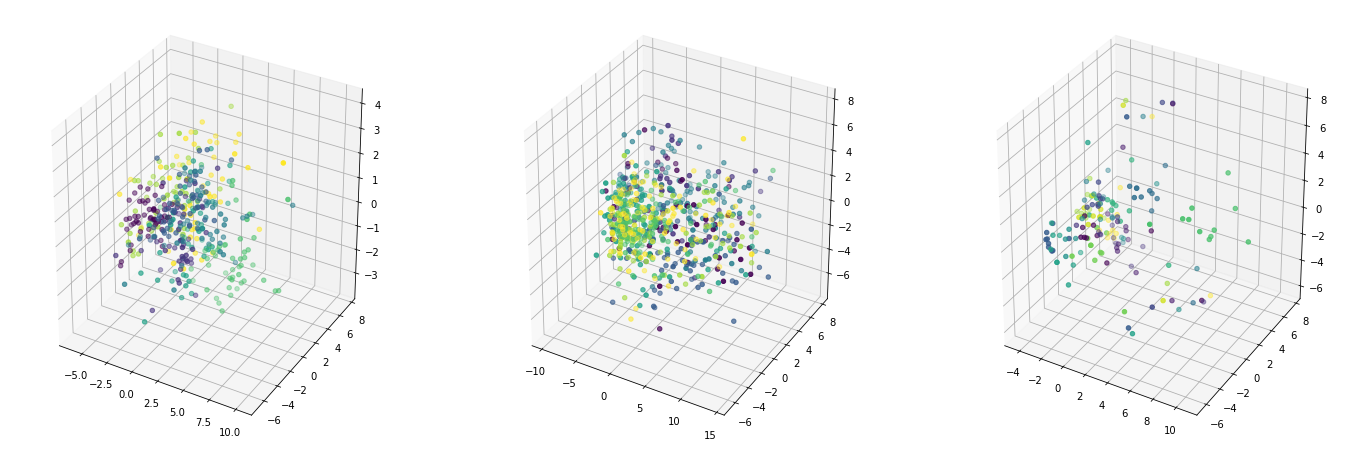

In [18]:
# Create a scatter plot(3D)  

def callPCA(X,N,H,W,C):
    X=X.reshape((N,H*W*C))
    X,j=get_pca(X,3)
    return X
fig = plt.figure(figsize=(24,8))
X11 = callPCA(X1,N1,H1,W1,C1)
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X11[:,0],X11[:,1],X11[:,2],c=y1)

X22 = callPCA(X2,N2,H2,W2,C2)
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X22[:,0],X22[:,1],X22[:,2],c=y2)


X33 = callPCA(X3,N3,H3,W3,C3)
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X33[:,0],X33[:,1],X33[:,2],c=y3)
plt.show();

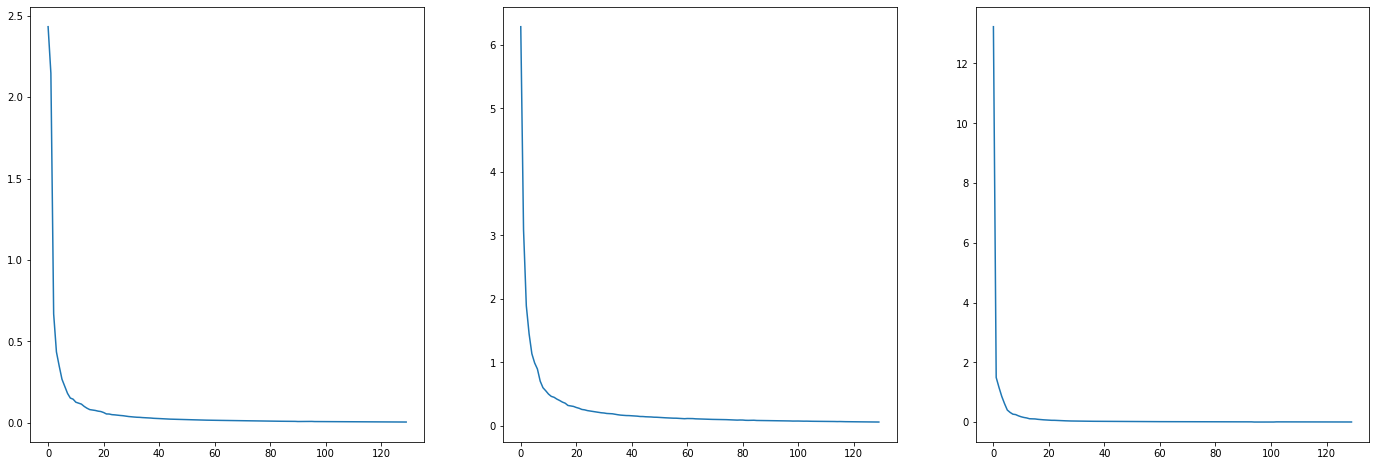

In [19]:
# Plot the eigen value spectrum 

def calculateEigenValue(X,N,W,H,C):
    a=X.reshape((N,W*H*C))
    C=np.cov(a)
    E=np.linalg.eigvals(C)
    E = np.abs(E)
    X=np.arange(130)
    return X,E
S = 130

fig = plt.figure(figsize=(24,8))
X11, E1 = calculateEigenValue(X1,N1,W1,H1,C1)
ax1 = fig.add_subplot(131)
ax1.plot(X11,E1[0:S])

X22, E2 = calculateEigenValue(X2,N2,W2,H2,C2)
ax1 = fig.add_subplot(132)
ax1.plot(X22,E2[0:S])

X33, E3 = calculateEigenValue(X3,N3,W3,H3,C3)
ax3 = fig.add_subplot(133)
ax3.plot(X33,E3[0:S])

plt.show()

1(c). Reconstruct  the  image  back for each case


In [20]:
def reconstruct_images(X,N,H,W,C,K):
    _,Xt=get_pca(X,K)
    Xt=Xt.reshape((N,H,W))
    return Xt

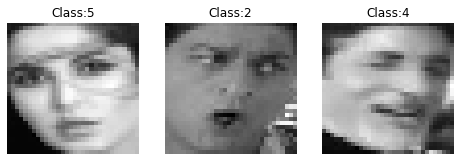

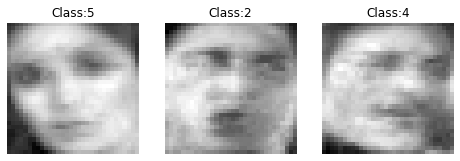

0.05573707684520565


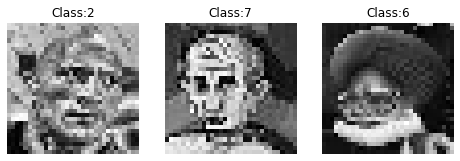

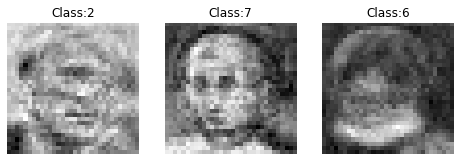

0.12866232620152215


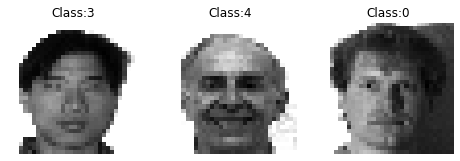

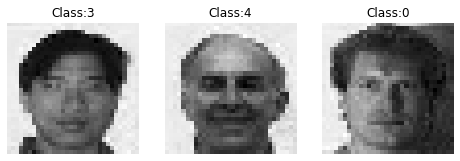

0.03154585955162053


In [21]:
# Display results 

X1_reconstruced = reconstruct_images(X1.reshape(N1,H1*W1*C1),N1,H1,W1,C1,50)
ind = np.random.randint(0,y1.shape[0],6)
disply_images(X1[ind,...],y1[ind], row=1,col=3)
disply_images(X1_reconstruced[ind,...],y1[ind], row=1,col=3)

print(np.sqrt(np.mean((X1-X1_reconstruced)**2)))

X2_reconstruced = reconstruct_images(X2.reshape(N2,H2*W2*C2),N2,H2,W2,C2,100)
ind = np.random.randint(0,y2.shape[0],6)
disply_images(X2[ind,...],y2[ind], row=1,col=3)
disply_images(X2_reconstruced[ind,...],y2[ind], row=1,col=3)

print(np.sqrt(np.mean((X2-X2_reconstruced)**2)))

X3_reconstruced = reconstruct_images(X3.reshape(N3,H3*W3*C3),N3,H3,W3,C3,100)
ind = np.random.randint(0,y3.shape[0],6)
disply_images(X3[ind,...],y3[ind], row=1,col=3)
disply_images(X3_reconstruced[ind,...],y3[ind], row=1,col=3)
print(np.sqrt(np.mean((X3-X3_reconstruced)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers
___________________________

In [22]:
def error(x,y,X,X_reconstructed,Y):
    C = np.zeros(x)
    D = np.zeros(x)
    for i in range(y):
        C[Y[i]] += 1
        D[Y[i]] += np.mean((X[i]-X_reconstructed[i])**2)
    print(D)
    print(np.argmax(D/C))
    
error(8, 400, X1, X1_reconstruced,y1)
error(8, 672, X2, X2_reconstruced,y2)
error(15, 165, X3, X3_reconstruced,y3)

[0.11414179 0.14956807 0.14574558 0.17844061 0.16742464 0.15729113
 0.15292051 0.17711637]
3
[0.68397203 0.67938492 0.96781955 1.43902891 1.63793286 2.02669057
 1.9355138  1.75394146]
5
[0.01359122 0.01136669 0.00854446 0.0132437  0.012435   0.01190802
 0.00905325 0.00747888 0.0072663  0.01147319 0.00813273 0.0112841
 0.01272139 0.01403248 0.01166689]
13


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [23]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self,classifier,maxiter=1000,kernel="linear",gamma="auto",degree=3,hidden=(5000,)):
        
        if(classifier=="SVM"):
            self.classifier=SVC(C=1,max_iter=maxiter,kernel=kernel,gamma=gamma,degree=degree)
        elif(classifier=="LOGISTIC"):
            self.classifier=LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial')
        elif(classifier=="MLP"):
            self.classifier=MLPClassifier(hidden_layer_sizes=hidden)
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
  
        prediction=self.classifier.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm=confusion_matrix(y,pred)
        return cm
    
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train,y_train)

        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        predicition=self.classify(X_validate)
        cm=self.confusion_matrix(predicition,y_validate)
        accuracy=accuracy_score(y_validate,predicition)
        precision,recall,f1s,j=precision_recall_fscore_support(y_validate,predicition,average="micro")
        return [f1s,accuracy,precision,recall,cm]

In [38]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

def splitdata(X,Y,N):
    s=np.arange(X.shape[0])
    np.random.shuffle(s)
    X=X[s]
    Y=Y[s]
    t=(N/10)*8
    t=int(t)
    Xtr=X[0:t]
    Ytr=Y[0:t]
    Xte=X[t:N]
    Yte=Y[t:N]
    return Xtr,Ytr,Xte,Yte


def initfc(X,Y,N,W,H,C,f,c,path):
    #flatten
    X=X.reshape((N,W*H*C))
    
    Feature_List = ["PCA","KPCA", "LDA", "KLDA","VGG","RESNET"];
    
    #select feature
    if(f==Feature_List[0]):
        X,j=get_pca(X,50)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f==Feature_List[1]):
        X=get_kernel_pca(X,50)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f==Feature_List[2]):
        X=get_lda(X,Y,50)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f==Feature_List[3]):
        X=get_kernel_lda(X,Y,50)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f==Feature_List[4]):
        X=get_vgg_features(path)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f==Feature_List[5]):
        X=get_resnet_features(path)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
        
    Classifier_List = ["SVM", "LOGISTIC","MLP" ];
    
    #select classifier
    if(c==Classifier_List[0]):
        classifier=Classifier("SVM")
        classifier.train(Xtr,Ytr)
    elif(c==Classifier_List[1]):
        classifier=Classifier("LOGISTIC")
        classifier.train(Xtr,Ytr)
    elif(c==Classifier_List[2]):
        classifier=Classifier("MLP",hidden=(50,10))
        classifier.train(Xtr,Ytr)
        
    #testing
    f1s,acc,precision,recall,cm=classifier.validate(Xte,Yte)
    
    #add to list for printing later
    temp=[]
    temp.append(f+" with "+c)
    temp.append(Xtr.shape[1])
    temp.append(1-acc)
    temp.append(acc)
    temp.append(f1s)
    
    return [temp,acc,cm]
        
    
def pprint1(x):
    cellwidth=25

    #print row seperator
    head=' '
    for i in range(len(x)):
        head+='-'*cellwidth
        head+=' '
    print(head)

    print('|',end='')
    for i in x:
        i=str(i)
        i=i.center(cellwidth)#ljust,rjust,center
        print(i,end='|')

    #print newline after each record
    print()
    

def func(X,Y,N,W,H,C,path,d):
    Feature_List = ["PCA","KPCA","LDA","KLDA","VGG","RESNET"]
    Classifier_List = ["SVM","LOGISTIC","MLP"]
    Table=[]
    Bestcm=[]

    for f in Feature_List:
        for c in Classifier_List:
#             X = np.array(X).astype(int)
            X = X.reshape((1,-1))
            temp,acc,cm=initfc(X,Y,N,W,H,C,f,c,path)
            Table.append(temp)
            Bestcm.append([acc,cm])

    # printing
    print("Results for dataset-"+str(d))
    Table.insert(0,["Feature","Red dimen.","Error","Accuracy","F1-score"])
    for i in Table:
        pprint1(i)
    print("")
    print("")
    return Bestcm

    

bestcm1=func(X1,y1,N1,W1,H1,C1,"./dataset/IMFDB",1)
bestcm2=func(X2,y2,N2,W2,H2,C2,"./dataset/IIIT-CFW",2)
bestcm3=func(X3,y3,N3,W3,H3,C3,"./dataset/Yale_face_database",3)

/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min

Results for dataset-1
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |        Red dimen.       |          Error          |         Accuracy        |         F1-score        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with SVM      |            50           |   0.32499999999999996   |          0.675          |          0.675          |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|    PCA with LOGISTIC    |            50           |   0.19999999999999996   |           0.8           |    0.8000000000000002   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with MLP      |            50           | 

/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/killer

Results for dataset-2
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |        Red dimen.       |          Error          |         Accuracy        |         F1-score        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with SVM      |            50           |    0.5777777777777777   |    0.4222222222222222   |    0.4222222222222222   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|    PCA with LOGISTIC    |            50           |    0.5481481481481482   |   0.45185185185185184   |   0.45185185185185184   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with MLP      |            50           | 

/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 15 - 1) = 14 components.
  ChangedBehaviorWarning)
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a Va

Results for dataset-3
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |        Red dimen.       |          Error          |         Accuracy        |         F1-score        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with SVM      |            50           |   0.030303030303030276  |    0.9696969696969697   |    0.9696969696969697   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|    PCA with LOGISTIC    |            50           |   0.12121212121212122   |    0.8787878787878788   |    0.8787878787878788   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with MLP      |            50           | 

In [25]:
# For each dataset print the confusion matrix for the best model 
def printcm(CM,i):
    print("Confusion Matrix for dataset-"+str(i)+"\n")
    CM.sort(key=lambda x:x[0],reverse=True)
    print(CM[0][1])
    print("\n")

printcm(bestcm1,1)
printcm(bestcm2,2)
printcm(bestcm3,3)

Confusion Matrix for dataset-1

[[13  1  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0]
 [ 1  0  6  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 12  0]
 [ 0  0  1  0  0  0  0  8]]


Confusion Matrix for dataset-2

[[13  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0]
 [ 0  1  0 15  0  1  0  0]
 [ 0  0  0  0 21  0  0  0]
 [ 0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  1  0 19]]


Confusion Matrix for dataset-3

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5]]




3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [26]:
def applytsne(X,N,H,W,C,k):
    X=X.reshape((N,H*W*C))
    X=TSNE(n_components=k).fit_transform(X)
    return X
    
#3D plot
p1=applytsne(X1,N1,H1,W1,C1,3)
p2=applytsne(X2,N2,H2,W2,C2,3)
p3=applytsne(X3,N3,H3,W3,C3,3)

#2D plot
p4=applytsne(X1,N1,H1,W1,C1,2)
p5=applytsne(X2,N2,H2,W2,C2,2)
p6=applytsne(X3,N3,H3,W3,C3,2)

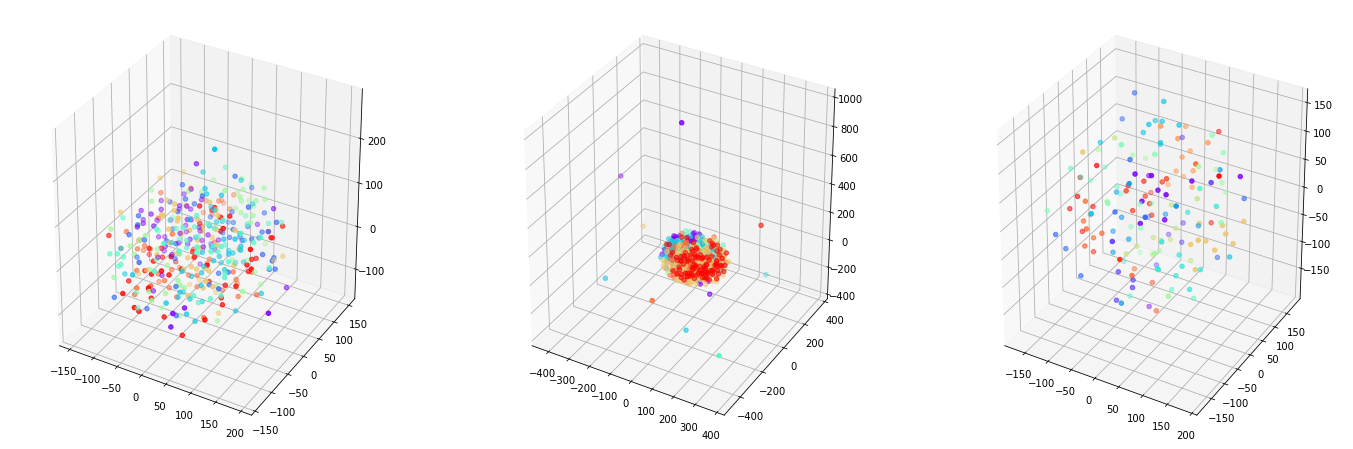

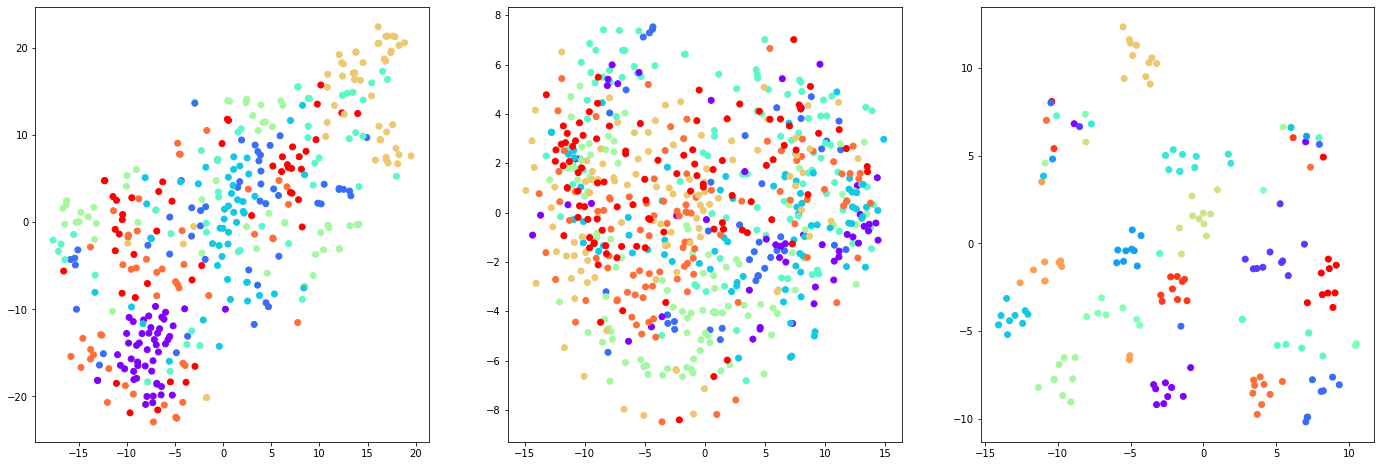

In [27]:
def print3D(X,Y,s):
    N=np.unique(Y).shape[0]
    C=[0]*len(X)
    colors=cm.rainbow(np.linspace(0, 1, N))
    for i in range(len(Y)):
        C[i]=colors[Y[i]]
    ax=fig.add_subplot(s,projection='3d')
    ax.scatter(X[:,0],X[:,1],X[:,2],color=C)
        
def print2D(X,Y,s):
    N=np.unique(Y).shape[0]
    C=[0]*len(X)
    colors=cm.rainbow(np.linspace(0, 1, N))
    for i in range(len(Y)):
        C[i]=colors[Y[i]]
    ax=fig.add_subplot(s)
    ax.scatter(X[:,0],X[:,1],color=C)


#3D plot     
fig=plt.figure(figsize=(24,8))
print3D(p1,y1,131)
print3D(p2,y2,132)
print3D(p3,y3,133)

#2D plot
fig=plt.figure(figsize=(24,8))
print2D(p4,y1,131)
print2D(p5,y2,132)
print2D(p6,y3,133)

In [28]:
Xcomb=np.vstack((X1,X2))
Xcomb=np.vstack((Xcomb,X3))
print(Xcomb.shape)

t=copy.deepcopy(y2)
for i in range(len(t)):
    t[i]=t[i]+8

Ycomb=np.hstack((y1,t))

t=copy.deepcopy(y3)
for i in range(len(t)):
    t[i]=t[i]+16

Ycomb=np.hstack((Ycomb,t))
print(Ycomb.shape)

p7=applytsne(Xcomb,Xcomb.shape[0],H1,W1,C1,3)
p8=applytsne(Xcomb,Xcomb.shape[0],H1,W1,C1,2)

(1237, 32, 32)
(1237,)


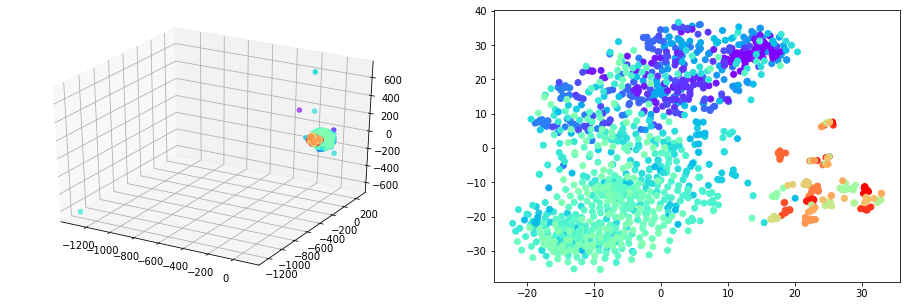

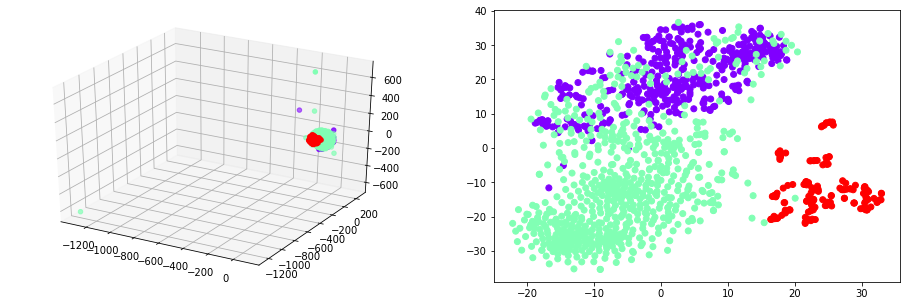

In [40]:
fig=plt.figure(figsize=(16,5))
print3D(p7,Ycomb,121)
print2D(p8,Ycomb,122)

t=[]
for i in range(X1.shape[0]):
    t.append(0)
for i in range(X2.shape[0]):
    t.append(1)
for i in range(X3.shape[0]):
    t.append(2)

fig=plt.figure(figsize=(16,5))
print3D(p7,t,121)
print2D(p8,t,122)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 


4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [41]:
# Create a train and validation split and show your results 

def preprocessdata(X,Y,N,H,W,C,f,d,k):
    
    X=X.reshape((N,H*W*C))
    
    if(f==0):
        X,j=get_pca(X,k)
    elif(f==1):
        X=get_kernel_pca(X,k)
    elif(f==2):
        X=get_lda(X,Y,k)
    elif(f==3):
        X=get_kernel_lda(X,Y,k)
    elif(f==4):
        X=get_vgg_features(d)
    elif(f==5):
        X=get_resnet_features(d)
        
    s=np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s],Y[s]


def datasplit(X,Y,N):
    t=(N/10)*7
    t=int(t)
    Xtr=X[0:t]
    Xte=X[t:N]
    Ytr=Y[0:t]
    Yte=Y[t:N]
    return Xtr,Ytr,Xte,Yte


def applyKNN(X,Y):
    neigh=KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X,Y)
    return neigh


def testKNN(M,X,Y,N):
    acc=0
    TP=0
    FP=0
    global cans
    Ytemp=[]
    for i in range(len(Y)):
        t=np.random.randint(0,8,1)
        Ytemp.append(t)
    for i in range(len(X)):
        cans=0
        if(Ytemp[i]==Y[i]):
            cans=1
        pans=0
        pred=M.predict([X[i]])
        if(pred==Ytemp[i]):
            pans=1
        if(cans==pans):
            acc+=1
        if(cans==1 and pans==1):
            TP+=1
        if(cans==0 and pans==1):
            FP+=1
    err=(N-acc)/N
    acc=acc/N
    pre=(TP/(TP+FP))
    return err,acc,pre


def pprint(x):
    cellwidth=25

    head=' '
    for i in range(len(x)):
        head+='-'*cellwidth
        head+=' '
    print(head)

    print('|',end='')
    for i in x:
        i=str(i)
        i=i.center(cellwidth)
        print(i,end='|')

    print()
    
    
def printtable(T):
    T.insert(0,["Feature","Red dimen.","Error","Accuracy","Precision"])
    for i in T:
        pprint(i)

def final(val):
    Table=[]
    Feature_List = ["PCA","KPCA","LDA","KLDA","VGG","RESNET"]
    for i in range(6):
        t=[]
        k=0
        if(i==0):
            k=20
            t.append(Feature_List[0])
            t.append(k)
        elif(i==1):
            k=20
            t.append(Feature_List[1])
            t.append(k)
        elif(i==2):
            k=2
            t.append(Feature_List[2])
            t.append(2)
        elif(i==3):
            k=2
            t.append(Feature_List[3])
            t.append(k)
        elif(i==4):
            t.append(Feature_List[4])
            t.append("-")
        elif(i==5):
            t.append(Feature_List[5])
            t.append("-")

        if val == 1:
            Xt,Yt=preprocessdata(X1,y1,N1,H1,W1,C1,i,"./dataset/IMFDB",k)
            N = N1
        elif val == 2:
            Xt,Yt=preprocessdata(X2,y2,N2,H2,W2,C2,i,"./dataset/IIIT-CFW",k)
            N = N2
        else:
            Xt,Yt=preprocessdata(X3,y3,N3,H3,W3,C3,i,"./dataset/Yale_face_database",k)
            N = N3
        Xtr,ytr,Xte,yte=datasplit(Xt,Yt,N)
        Xm=applyKNN(Xtr,ytr)
        err,acc,pre=testKNN(Xm,Xte,yte,Xte.shape[0])
        t.append(err)
        t.append(acc)    
        t.append(pre)   
        Table.append(t)

    printtable(Table)    

final(1)
final(2)
final(3)

/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |        Red dimen.       |          Error          |         Accuracy        |        Precision        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           PCA           |            20           |   0.10833333333333334   |    0.8916666666666667   |    0.6111111111111112   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           KPCA          |            20           |   0.11666666666666667   |    0.8833333333333333   |    0.3333333333333333   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           LDA           |            2            |          0.075        

/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |        Red dimen.       |          Error          |         Accuracy        |        Precision        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           PCA           |            20           |   0.15346534653465346   |    0.8465346534653465   |   0.34615384615384615   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           KPCA          |            20           |   0.16336633663366337   |    0.8366336633663366   |   0.41935483870967744   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           LDA           |            2            |   0.034653465346534656

/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/killer00/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |        Red dimen.       |          Error          |         Accuracy        |        Precision        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           PCA           |            20           |           0.04          |           0.96          |    0.8333333333333334   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           KPCA          |            20           |           0.06          |           0.94          |           0.8           |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           LDA           |            2            |           0.02        

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [42]:
#Load data and apply resnet
t1=X1.reshape((N1,W1*H1*C1))
t2=X2.reshape((N2,W2*H2*C2))
XX=np.vstack((t1,t2))

t1=get_resnet_features("./dataset/Yale_face_database/")
t2=get_resnet_features("./dataset/IIIT-CFW")
X=np.vstack((t1,t2))
N=X.shape[0]

t1=np.zeros(X1.shape[0])
t2=np.ones(X2.shape[0])
Y=np.hstack((t1,t2))


s=np.arange(N)
np.random.shuffle(s)
XX=XX[s]
X=X[s]
Y=Y[s]


t=int((N/10)*8)
XX=XX[t:N]
Xtr=X[0:t]
Xte=X[t:N]
Ytr=Y[0:t]
Yte=Y[t:N]



In [43]:
#Define your features
print("Using KNN along with resnet")

Using KNN along with resnet


In [44]:
#Create your classifier
M=applyKNN(Xtr,Ytr)

def testKNN2(M,X,Y,N,XX):
    acc=0
    TP=0
    FP=0
    plot1=[]
    plot2=[]
    plot3=[]
    Ytemp=[]
    for i in range(len(Y)):
        t=np.random.randint(0,2,1)
        Ytemp.append(t)
    for i in range(len(X)):
        cans=0
        if(Ytemp[i]==Y[i]):
            cans=1
        pans=0
        pred=M.predict([X[i]])
        if(pred==Ytemp[i]):
            pans=1
        if(cans==pans):
            acc+=1
            plot1.append(XX[i])
            plot2.append(Y[i])
            plot3.append(pred)
        if(cans==1 and pans==1):
            TP+=1
        if(cans==0 and pans==1):
            FP+=1
            
    err=(N-acc)/N
    acc=acc/N
    pre=(TP/(TP+FP))
    plot1=np.array(plot1)
    plot2=np.array(plot2)
    plot3=np.array(plot3)
    return err,acc,pre,plot1,plot2,plot3

Precision:  0.9594594594594594
Accuracy:  0.9583333333333334
Error:  0.041666666666666664


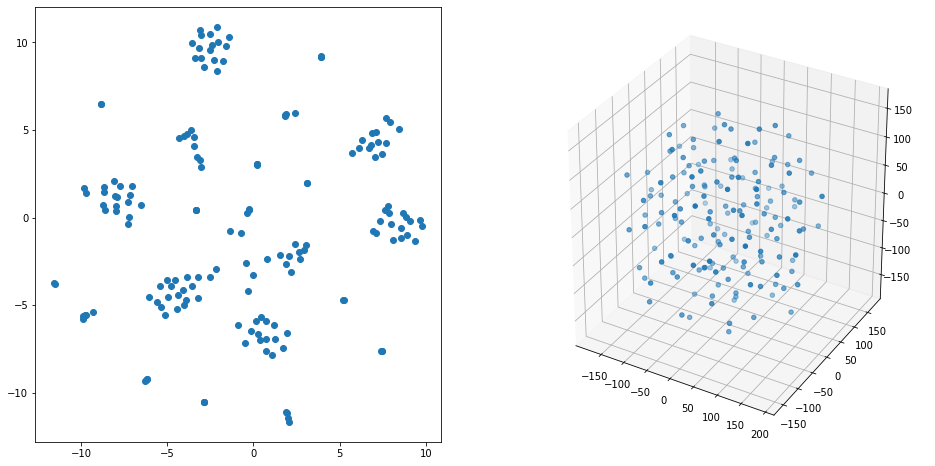

In [45]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
E,A,P,plot1,plot2,plot3=testKNN2(M,Xte,Yte,Xte.shape[0],XX)
print("Precision: ",str(P))
print("Accuracy: ",str(A))
print("Error: ",str(E))

fig=plt.figure(figsize=(16,8))
X_temp1=TSNE(n_components=2).fit_transform(Xte)
X_temp2=TSNE(n_components=3).fit_transform(Xte)

ax1=fig.add_subplot(121)
ax1.scatter(X_temp1[:,0],X_temp1[:,1])

ax2=fig.add_subplot(122,projection='3d')
ax2.scatter(X_temp2[:,0],X_temp2[:,1],X_temp2[:,2])
plt.show()

True Labels


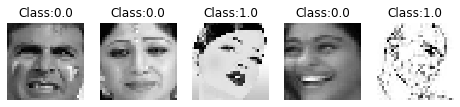

Predcted Labels


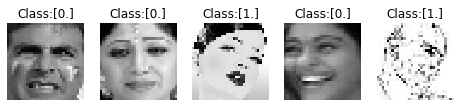

In [46]:
# Show quantitative results such as examples of correct prediction and wrong prediction
plot1=plot1.reshape((plot1.shape[0],32,32))

ind = np.random.randint(0,plot2.shape[0],5)
print("True Labels")
disply_images(plot1[ind,...],plot2[ind], row=1,col=5)
print("Predcted Labels")
disply_images(plot1[ind,...],plot3[ind], row=1,col=5)